In [1]:
#%tensorflow_version 1.x
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.4.3


In [2]:
warnings.filterwarnings('ignore') 
inceptionV3_model = keras.applications.inception_v3.InceptionV3() #Load pretrained model
#inceptionV3_model.summary()

96116736/96112376 [==============================] - 1s 0us/step


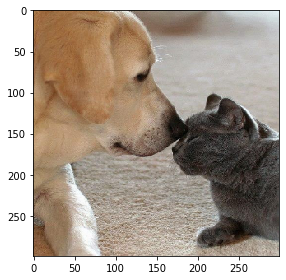

In [3]:
Xi = skimage.io.imread("https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

In [4]:
np.random.seed(222)
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds)[0] #Top 5 classes

40960/35363 [==================================] - 0s 0us/step


[('n02099712', 'Labrador_retriever', 0.82733464),
 ('n02099601', 'golden_retriever', 0.014789652),
 ('n02093428', 'American_Staffordshire_terrier', 0.008711377),
 ('n02108422', 'bull_mastiff', 0.008177903),
 ('n02109047', 'Great_Dane', 0.007899415)]

In [5]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes                #Index of top 5 classes

array([208, 207, 180, 243, 246])

In [6]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

68

In [7]:
Xi.shape

(299, 299, 3)

In [8]:
np.unique(superpixels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

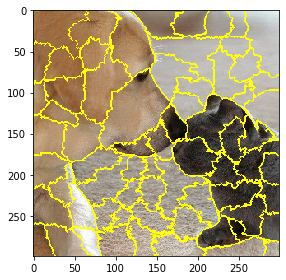

In [9]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [10]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1])

In [11]:
def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
          mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

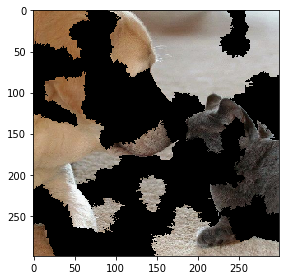

In [12]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [13]:
predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(Xi,pert,superpixels)
    pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
    predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 1000)

In [14]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [15]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [16]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.01998328, -0.01601363,  0.10354326, -0.04821645,  0.08925861,
        0.07826834,  0.02714029,  0.07659395,  0.18122353, -0.05638611,
        0.03509668,  0.00470349,  0.02208899,  0.1035666 ,  0.07223705,
        0.00347347,  0.0816289 ,  0.03907228,  0.00769066,  0.02527205,
       -0.01004959,  0.02130278, -0.07029262, -0.02555172,  0.52121133,
        0.02055338,  0.00131833, -0.17025001, -0.03082528,  0.14881243,
        0.05691062,  0.10112551, -0.01224573, -0.04081393, -0.03864293,
       -0.02153385, -0.05745936,  0.02746967,  0.03796638,  0.03152443,
        0.03358085,  0.00733323,  0.04806783, -0.02303109, -0.01457866,
        0.08431807,  0.00803587, -0.0194588 , -0.09000501,  0.05641908,
        0.02874253,  0.01926135, -0.0365345 ,  0.03901721, -0.05825469,
        0.03474149, -0.1026879 ,  0.00780916, -0.03470877,  0.03349181,
        0.06900848, -0.05142001,  0.02219399,  0.05436454,  0.01072264,
       -0.03208539,  0.09252425, -0.00573749])

In [17]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([13, 29,  8, 24])

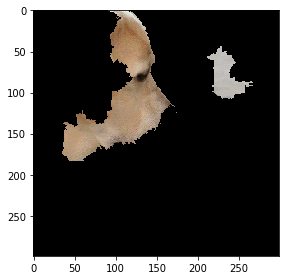

In [18]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

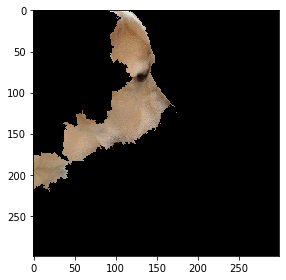

In [19]:
def xwhy_image(X_input, model, num_perturb = 150, kernel_width = 0.25):
    
    superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    
    def perturb_image(img,perturbation,segments):
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)
        for active in active_pixels:
              mask[segments == active] = 1 
        perturbed_image = copy.deepcopy(img)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        return perturbed_image
    
    predictions = []
    for pert in perturbations:
        perturbed_img = perturb_image(Xi,pert,superpixels)
        pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)

    predictions = np.array(predictions)
    
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
    
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
        
    return coeff, perturbations

coeff, perturbations = xwhy_image(Xi, model=inceptionV3_model)

num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

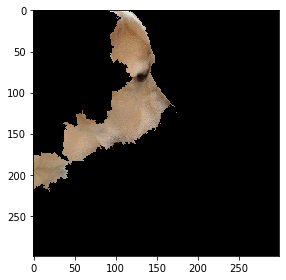

In [20]:
def Wasserstein_Dist(XX, YY):
  
    import numpy as np
    nx = len(XX)
    ny = len(YY)
    n = nx + ny

    XY = np.concatenate([XX,YY])
    X2 = np.concatenate([np.repeat(1/nx, nx), np.repeat(0, ny)])
    Y2 = np.concatenate([np.repeat(0, nx), np.repeat(1/ny, ny)])

    S_Ind = np.argsort(XY)
    XY_Sorted = XY[S_Ind]
    X2_Sorted = X2[S_Ind]
    Y2_Sorted = Y2[S_Ind]

    Res = 0
    E_CDF = 0
    F_CDF = 0
    power = 1

    for ii in range(0, n-2):
        E_CDF = E_CDF + X2_Sorted[ii]
        F_CDF = F_CDF + Y2_Sorted[ii]
        height = abs(F_CDF-E_CDF)
        width = XY_Sorted[ii+1] - XY_Sorted[ii]
        Res = Res + (height ** power) * width;  
 
    return Res

def  Wasserstein_Dist_PVal(XX, YY):
    # Information about Bootstrap: 
    # https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60
    import random
    nboots = 1000
    WD = Wasserstein_Dist(XX,YY)
    na = len(XX)
    nb = len(YY)
    n = na + nb
    comb = np.concatenate([XX,YY])
    reps = 0
    bigger = 0
    for ii in range(1, nboots):
        e = random.sample(range(n), na)
        f = random.sample(range(n), nb)
        boost_WD = Wasserstein_Dist(comb[e],comb[f]);
        if (boost_WD > WD):
            bigger = 1 + bigger
            
    pVal = bigger/nboots;

    return pVal, WD

def Wasserstein_Dist_Image(img1, img2):
    if img1.shape[0] != img2.shape[0] or img1.shape[1] != img2.shape[1]:
        pritn('input images should have the same size')
    else:
        WD = []
        for ii in range(3):
            
            im1 = np.array(img1[:,:,ii].flatten())
            im2 = np.array(img2[:,:,ii].flatten())

            WD.append(Wasserstein_Dist(im1, im2))
            
    return sum(WD)
  
def xwhy_image2(X_input, model, perturbations=perturbations, num_perturb = 150, kernel_width = 0.25):
    
    superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    #perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    
    
    def perturb_image(img,perturbation,segments):
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)
        for active in active_pixels:
              mask[segments == active] = 1 
        perturbed_image = copy.deepcopy(img)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        return perturbed_image
    
    predictions = []
    WD_dist = []
    for pert in perturbations:
        perturbed_img = perturb_image(Xi,pert,superpixels)
        pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)
        WD_dist = Wasserstein_Dist_Image(Xi, perturbed_img)
        

    predictions = np.array(predictions)
    
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    # distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    
    
    weights = np.sqrt(np.exp(-(WD_dist**2)/kernel_width**2)) #Kernel function
    
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
        
    return coeff

coeff = xwhy_image2(Xi, model=inceptionV3_model)

num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

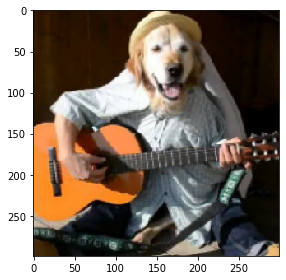

In [21]:
Xi = skimage.io.imread("../input/lime-img-ex/LIME_Img_ex.JPG")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

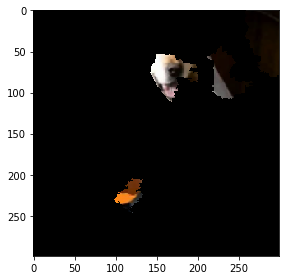

In [22]:
coeff, perturbations = xwhy_image(Xi, model=inceptionV3_model)

num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

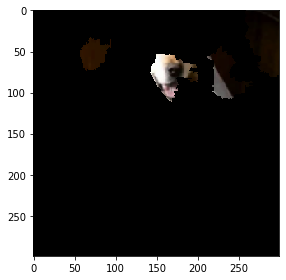

In [23]:
coeff = xwhy_image2(Xi, model=inceptionV3_model)

num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

## MNIST - Comparison to other Approaches
For model-specific approaches like LRP, [innvestigate pacakge](https://github.com/albermax/innvestigate/blob/master/examples/notebooks/mnist_compare_methods.ipynb) notebook is used.

In [24]:
# Source: https://www.kaggle.com/kooaslansefat/evidential-deep-learning-reliability
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import keras
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras import backend as K

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=20)

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/20
469/469 [==============================] - 84s 179ms/step - loss: 0.2990 - accuracy: 0.9088
Epoch 2/20
469/469 [==============================] - 82s 176ms/step - loss: 0.0392 - accuracy: 0.9881
Epoch 3/20
469/469 [==============================] - 83s 177ms/step - loss: 0.0218 - accuracy: 0.9936
Epoch 4/20
469/469 [==============================] - 82s 175ms/step - loss: 0.0128 - accuracy: 0.9957
Epoch 5/20
469/469 [==============================] - 83s 176ms/step - loss: 0.0096 - accuracy: 0.9966
Epoch 6/20
469/469 [==============================] - 82s 176ms/step - loss: 0.0066 - accuracy: 0.9979
Epoch 7/20
469/469 [==============================] - 83s 176ms/step - loss: 0.0053 - accuracy: 0.9984
Epoch 8/20
469/469 [==============================] - 83s 177ms/step - loss: 0.0032 - accuracy: 0.9990
Epoch 9/20
469/469 [==============================] - 82s 176ms/step - loss: 0.0072 - accuracy: 0.9972
Epoch 10

In [25]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.0544612742960453
Test accuracy: 0.9887999892234802


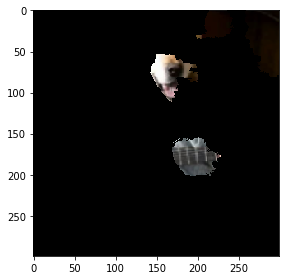

In [26]:
coeff, perturbations = xwhy_image(Xi, model=model)

num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )